In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt, gc, os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet
/kaggle/input/amex-data-integer-dtypes-parquet-format/test.parquet
/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import os
import lightgbm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay, accuracy_score
import shap
import itertools

In [3]:
#Because the files are too large to read,so use the parquet file format.
train = pd.read_parquet("/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet")
test = pd.read_parquet("/kaggle/input/amex-data-integer-dtypes-parquet-format/test.parquet")
train_labels = pd.read_csv("../input/amex-default-prediction/train_labels.csv")
train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,NaN,0,0.000610,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,NaN,0,0.005492,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,NaN,0,0.006986,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,NaN,0,0.006527,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,NaN,0,0.008126,0


In [4]:
#shapes
train.shape, test.shape, train_labels.shape

((5531451, 190), (11363762, 190), (458913, 2))

In [5]:
print('Number of row:'+str(len(train)))
print('Number of column:'+str(len(train.columns)))

Number of row:5531451
Number of column:190


In [6]:
train.describe()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
count,5.485466e+06,5.531451e+06,5.531451e+06,5.529435e+06,5.531451e+06,4.510907e+06,5.529435e+06,5.529435e+06,791314.000000,3.873055e+06,...,5.531451e+06,5.531451e+06,5.531451e+06,5.531451e+06,5.531451e+06,5.429903e+06,944408.000000,5.531451e+06,5.490724e+06,5.531451e+06
mean,6.563343e-01,5.035986e+00,1.240101e-01,6.214890e-01,7.880273e-02,2.258454e-01,5.543458e-02,1.325390e-01,0.184974,1.546841e-01,...,-9.313243e-01,-9.644764e-01,-9.535646e-01,1.523781e-01,1.413933e-02,1.603911e-01,0.390799,1.522530e-01,5.238953e-02,6.007445e-01
std,2.446494e-01,9.181833e+00,2.119869e-01,4.014876e-01,2.263971e-01,1.933475e-01,2.037066e-01,2.349929e-01,0.228185,2.133977e-01,...,3.926067e-01,1.868469e-01,2.629447e-01,4.072783e-01,1.692060e-01,3.501590e-01,0.236182,4.071715e-01,1.825135e-01,2.119894e+00
min,-4.589548e-01,0.000000e+00,-7.588799e+00,9.192280e-09,1.534223e-09,-6.271321e-01,0.000000e+00,6.285293e-09,-0.000454,1.154550e-07,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-0.014539,-1.000000e+00,2.500991e-09,-1.000000e+00
25%,4.803307e-01,0.000000e+00,8.863645e-03,1.053313e-01,2.895934e-03,1.272588e-01,0.000000e+00,5.227570e-03,0.037516,4.227546e-02,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.199399,0.000000e+00,2.752895e-03,0.000000e+00
50%,6.942950e-01,0.000000e+00,3.132968e-02,8.143328e-01,5.782230e-03,1.639082e-01,0.000000e+00,9.777229e-03,0.120519,8.851244e-02,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.382136,0.000000e+00,5.508129e-03,0.000000e+00
75%,8.648159e-01,8.000000e+00,1.259019e-01,1.002403e+00,8.660590e-03,2.581017e-01,0.000000e+00,1.550507e-01,0.250869,1.843206e-01,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.559307,0.000000e+00,8.260448e-03,0.000000e+00
max,1.010000e+00,1.830000e+02,1.324060e+00,1.010000e+00,3.256284e+00,5.482888e+00,8.988807e+00,1.625262e+00,4.191119,1.011162e+01,...,7.000000e+00,1.000000e+00,6.000000e+00,1.000000e+00,1.000000e+00,1.339910e+00,2.229368,1.000000e+00,1.343331e+00,5.300000e+01


In [7]:
#count NaN or missing values in the DataFrame
print('/nCount total NaN at each column in a DataFrame: /n/n',train.isnull().sum())

/nCount total NaN at each column in a DataFrame: /n/n customer_ID          0
S_2                  0
P_2              45985
D_39                 0
B_1                  0
                ...   
D_141           101548
D_142          4587043
D_143                0
D_144            40727
D_145                0
Length: 190, dtype: int64


In [8]:
#Columns that have more than 50% of missing values
columns=train.columns[train.isna().sum()/len(train)*100>50]
columns

Index(['D_42', 'D_50', 'D_53', 'D_56', 'S_9', 'B_17', 'D_73', 'D_76', 'B_29',
       'D_88', 'D_105', 'D_110', 'B_39', 'B_42', 'D_132', 'D_134', 'D_142'],
      dtype='object')

In [9]:
#Drop the columns which have more than 50% of missing values.
train = train.drop(columns, axis=1)
test = test.drop(columns, axis=1)

In [10]:
#lower than 50% but >0
na_rate_s = train.isna().sum()/len(train)*100

na_columns= list(na_rate_s [na_rate_s > 0].index)
na_columns

['P_2',
 'B_2',
 'S_3',
 'D_41',
 'B_3',
 'D_43',
 'D_45',
 'D_46',
 'D_48',
 'B_6',
 'B_8',
 'D_52',
 'P_3',
 'D_54',
 'S_7',
 'D_55',
 'B_13',
 'D_61',
 'B_15',
 'D_62',
 'D_69',
 'R_7',
 'D_77',
 'B_25',
 'B_26',
 'B_27',
 'R_12',
 'R_14',
 'S_22',
 'S_23',
 'S_24',
 'S_25',
 'S_26',
 'D_102',
 'D_104',
 'B_37',
 'R_27',
 'D_112',
 'B_40',
 'S_27',
 'D_115',
 'D_118',
 'D_119',
 'D_121',
 'D_128',
 'D_130',
 'D_131',
 'D_133',
 'D_141',
 'D_144']

In [11]:
#for the lower than 50% but >0 of missing values, we fill with median values.
for column in na_columns:
    fill_value = train[column].mean()
    train[column] = train[column].fillna(fill_value)
train.isna().sum()

customer_ID    0
S_2            0
P_2            0
D_39           0
B_1            0
              ..
D_140          0
D_141          0
D_143          0
D_144          0
D_145          0
Length: 173, dtype: int64

In [12]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [13]:
#Make the changes permanent
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [14]:
#shape
train.shape, train_labels.shape, test.shape

((5531451, 174), (458913, 2), (11363762, 174))

In [15]:
#skip this. 
categorical_col = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
for col in categorical_col:
    print(train[col].unique())
    print(test[col].unique())

[ 0  2  1 -1]
[ 0  1  2 -1]
[ 2  1  3  5  6  7  4 -1]
[ 1  2  5  3  6  7  4 -1]
[ 1  0 -1]
[-1  0  1]
[ 0 -1  1]
[-1  0  1]
[ 5  0  7  3  2 -1  4  6]
[-1  0  4  7  5  3  2  6]
[ 0  1 -1]
[-1  1  0]
[ 2 -1  1  0]
[ 1  2  0 -1]
[0 3 4 1 2 5]
[0 3 4 2 1 5]
[ 0  2 -1  3  1]
[-1  3  0  2]
[-1  1  0]
[-1  1]
[ 6  2  3 -1  5  4  0  1]
[-1  6  4  5  1  2  3]


In [16]:
import calendar 
calendar.monthrange(2023,1)

(6, 31)

In [17]:
import datetime 
def get_last_day(cur_date):
    year = cur_date.year
    month = cur_date.month
    last_day = calendar.monthrange(year,month)[1]
    return datetime.date(year,month,last_day)

In [18]:
train['S_2']

0          2017-03-09
1          2017-04-07
2          2017-05-28
3          2017-06-13
4          2017-07-16
              ...    
5531446    2017-11-05
5531447    2017-12-23
5531448    2018-01-06
5531449    2018-02-06
5531450    2018-03-14
Name: S_2, Length: 5531451, dtype: object

In [19]:
#although the original S_2 looks like datetime but actually numbers.so we make the S_2 to datetime.
train['S_2'] =pd.to_datetime(train['S_2'])


In [20]:
x = train.head(5)
x["S_2"].apply(get_last_day)

0    2017-03-31
1    2017-04-30
2    2017-05-31
3    2017-06-30
4    2017-07-31
Name: S_2, dtype: object

In [21]:
x

,index,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,...,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_143,D_144,D_145
0,0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,...,-1,-1,-1,-1,0,0,0.0,0,0.000610,0
1,1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,...,-1,-1,-1,-1,0,0,0.0,0,0.005492,0
2,2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,...,-1,-1,-1,-1,0,0,0.0,0,0.006986,0
3,3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,...,-1,-1,-1,-1,0,0,0.0,0,0.006527,0
4,4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,...,-1,-1,-1,-1,0,0,0.0,0,0.008126,0


In [22]:
train['month_last_date'] = train['S_2'].apply(get_last_day)
train.head()

,index,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,...,D_136,D_137,D_138,D_139,D_140,D_141,D_143,D_144,D_145,month_last_date
0,0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,...,-1,-1,-1,0,0,0.0,0,0.000610,0,2017-03-31
1,1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,...,-1,-1,-1,0,0,0.0,0,0.005492,0,2017-04-30
2,2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,...,-1,-1,-1,0,0,0.0,0,0.006986,0,2017-05-31
3,3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,...,-1,-1,-1,0,0,0.0,0,0.006527,0,2017-06-30
4,4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,...,-1,-1,-1,0,0,0.0,0,0.008126,0,2017-07-31


In [23]:
customer_last_date_series=train.groupby(by=['customer_ID','month_last_date'])['customer_ID'].count()
customer_last_date_series.sort_values(ascending=False)

customer_ID                                                       month_last_date
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a  2017-03-31         1
aa5ee11132972c48030b6d70bb5581030881c6a719eed89a7d6c2fae7c00b0d5  2018-02-28         1
aa5ee4d6e08edd3785feb1d22a2b743b360048733afe160963d1ea79e28ac0d3  2017-09-30         1
                                                                  2017-08-31         1
                                                                  2017-07-31         1
                                                                                    ..
551332666e152692d055673e6b5c4d91513b9b1b520b59d5536b1cb5d3360641  2017-10-31         1
                                                                  2017-09-30         1
                                                                  2017-08-31         1
                                                                  2017-07-31         1
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba

In [24]:
#this is to calculate how the number of customer in each datetime/month.
#Note that it's groupby using data of month_last_date and customer ID but actually we are calculating the customer_number so ".columns" is used to change the name of customer_id to cutomer_number
#Note that reset_index() is used to change the type from series to dateframe
month_customer_df = train.groupby(by='month_last_date')['customer_ID'].count().reset_index()
month_customer_df.columns = ['month_last_date','customer_number']
month_customer_df

,month_last_date,customer_number
0,2017-03-31,395630
1,2017-04-30,401556
2,2017-05-31,400306
3,2017-06-30,410384
4,2017-07-31,415602
5,2017-08-31,421099
6,2017-09-30,425455
7,2017-10-31,430292
8,2017-11-30,434268
9,2017-12-31,438910


In [25]:
train = pd.merge(left = train,right=train_labels,how='inner',on='customer_ID')
train.head()

,index,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,...,D_137,D_138,D_139,D_140,D_141,D_143,D_144,D_145,month_last_date,target
0,0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,...,-1,-1,0,0,0.0,0,0.000610,0,2017-03-31,0
1,1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,...,-1,-1,0,0,0.0,0,0.005492,0,2017-04-30,0
2,2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,...,-1,-1,0,0,0.0,0,0.006986,0,2017-05-31,0
3,3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,...,-1,-1,0,0,0.0,0,0.006527,0,2017-06-30,0
4,4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,...,-1,-1,0,0,0.0,0,0.008126,0,2017-07-31,0


In [26]:
#target came from merge of train and train_labels
train_labels['target'].value_counts()

0    340085
1    118828
Name: target, dtype: int64

In [27]:
month_default_df = train[train['target']==1].groupby(by='month_last_date')['customer_ID'].count().reset_index()
month_default_df.columns = ['month_last_date','default_number']
month_default_df.head()

,month_last_date,default_number
0,2017-03-31,91793
1,2017-04-30,94906
2,2017-05-31,95596
3,2017-06-30,99534
4,2017-07-31,102189


In [28]:
counter_df=pd.merge(left=month_customer_df,right=month_default_df,how ='outer',on='month_last_date')
counter_df

,month_last_date,customer_number,default_number
0,2017-03-31,395630,91793
1,2017-04-30,401556,94906
2,2017-05-31,400306,95596
3,2017-06-30,410384,99534
4,2017-07-31,415602,102189
5,2017-08-31,421099,104782
6,2017-09-30,425455,106784
7,2017-10-31,430292,108795
8,2017-11-30,434268,110607
9,2017-12-31,438910,112520


In [29]:
counter_df['pd_rate'] = counter_df['default_number'] / counter_df['customer_number']
counter_df

,month_last_date,customer_number,default_number,pd_rate
0,2017-03-31,395630,91793,0.232017
1,2017-04-30,401556,94906,0.236346
2,2017-05-31,400306,95596,0.238807
3,2017-06-30,410384,99534,0.242539
4,2017-07-31,415602,102189,0.245882
5,2017-08-31,421099,104782,0.248830
6,2017-09-30,425455,106784,0.250988
7,2017-10-31,430292,108795,0.252840
8,2017-11-30,434268,110607,0.254698
9,2017-12-31,438910,112520,0.256362


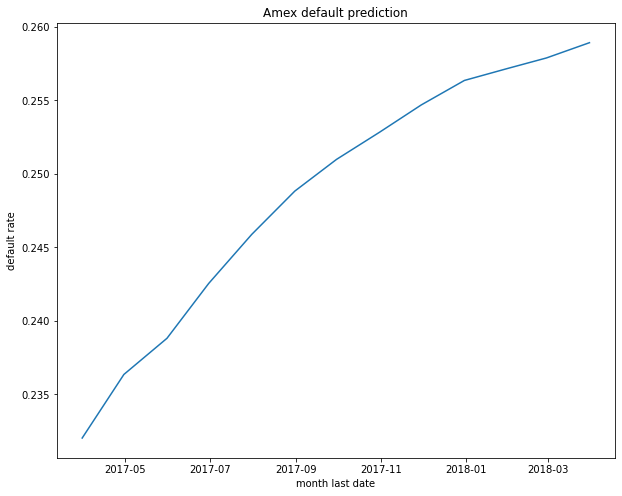

In [30]:
plt.figure(figsize = (10,8))
plt.plot(counter_df['month_last_date'],counter_df['pd_rate'])
plt.xlabel('month last date')
plt.ylabel('default rate')
plt.title('Amex default prediction')
plt.show()